In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 1/'
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import os
import numpy as np
import torch
import time
import torch.nn as nn
from torchvision.transforms import transforms
from torch.optim import lr_scheduler
from torchvision import datasets
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import copy
from torch.utils.tensorboard import SummaryWriter

# Create writer for tensorboard
writer = SummaryWriter('runs/DenseNet')

In [ ]:
# Slight data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

#Create datasets in dictionary with for loop passing in dir names and adding transform to tensor and normalize
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),data_transforms[x])
                  for x in ['train', 'val', 'test']}
#Load datasets in same way shuffle and make batch size 4 this can be tuned, workers at 2 for colab
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
#Similar process read in dataset sizes for accuracy later on
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#Read in classes from train, could be any as long as all directories have all classes
class_names = image_datasets['train'].classes

#Change to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Check what device is being used as well as dataset sizes
print(device)
print(dataset_sizes)

cuda:0
{'train': 1287, 'val': 389, 'test': 412}


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
  """
  Function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion loss function
    optimizer: Optimizer to use for training
    scheduler: Instance of torch.optim.lr_scheduler
    num_epochs: Number of epochs
    device: Device to run the training on, CUDA or CPU on colab.
  """
  #Time taken to train start
  since = time.time()

  #Copy current weights 
  best_model_wts = copy.deepcopy(model.state_dict())
  #Set accuracy
  best_acc = 0.0
  
  #For loop for training
  for epoch in range(num_epochs):
    #Printing epochs
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
      #Set running loss and correct count
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        #Send to device for training
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      #Step each train
      if phase == 'train':
        scheduler.step()
      #Calculate loss and accuracy
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      #Print loss accuracy and phase
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      #Send to tensorboard to be plotted
      if phase == 'train':
          writer.add_scalar('Training Loss', epoch_loss/1000, epoch * len(dataloaders['train']))
          writer.add_scalar('Training Accuracy', epoch_acc, epoch)
      else:
        writer.add_scalar('Validaiton Loss', epoch_loss/1000, epoch * len(dataloaders['val']))
        writer.add_scalar('Validation Accuracy', epoch_acc, epoch)

      # deep copy the model when decent score
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  #When complete calc time taken
  time_elapsed = time.time() - since
  #Print time taken and validation accuracy 
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights and send back trained model
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
#Call densenet201 model
densenet = torchvision.models.densenet201(pretrained=True)


#Set number of features to the num of features model will look for
num_ftrs = densenet.classifier.in_features
#Set feautres value and send num of classes
densenet.fc = nn.Linear(num_ftrs, 6)
#Set to device
densenet = densenet.to(device)
#Create loss function 
criterion = nn.CrossEntropyLoss() 

#Create optimiser for model
optimizer_conv = optim.SGD(densenet.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

#Set scheduler, decay learning rate by a factor of 0.3 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.3)

Epoch 0/24
----------
train Loss: 1.0076 Acc: 0.7382
val Loss: 0.2455 Acc: 0.9332

Epoch 1/24
----------
train Loss: 0.3853 Acc: 0.8936
val Loss: 0.1997 Acc: 0.9486

Epoch 2/24
----------
train Loss: 0.4207 Acc: 0.9060
val Loss: 0.3748 Acc: 0.8817

Epoch 3/24
----------
train Loss: 0.4807 Acc: 0.9106
val Loss: 0.4928 Acc: 0.9306

Epoch 4/24
----------
train Loss: 0.6648 Acc: 0.8695
val Loss: 0.5444 Acc: 0.8946

Epoch 5/24
----------
train Loss: 0.6022 Acc: 0.9138
val Loss: 0.2604 Acc: 0.9846

Epoch 6/24
----------
train Loss: 0.6267 Acc: 0.9254
val Loss: 0.3453 Acc: 0.9563

Epoch 7/24
----------
train Loss: 0.6309 Acc: 0.9239
val Loss: 0.3696 Acc: 0.9409

Epoch 8/24
----------
train Loss: 0.6608 Acc: 0.9138
val Loss: 0.3714 Acc: 0.9640

Epoch 9/24
----------
train Loss: 0.7109 Acc: 0.9005
val Loss: 0.5747 Acc: 0.8946

Epoch 10/24
----------
train Loss: 0.6256 Acc: 0.9340
val Loss: 0.2636 Acc: 0.9897

Epoch 11/24
----------
train Loss: 0.6272 Acc: 0.9355
val Loss: 0.2839 Acc: 0.9794

Ep

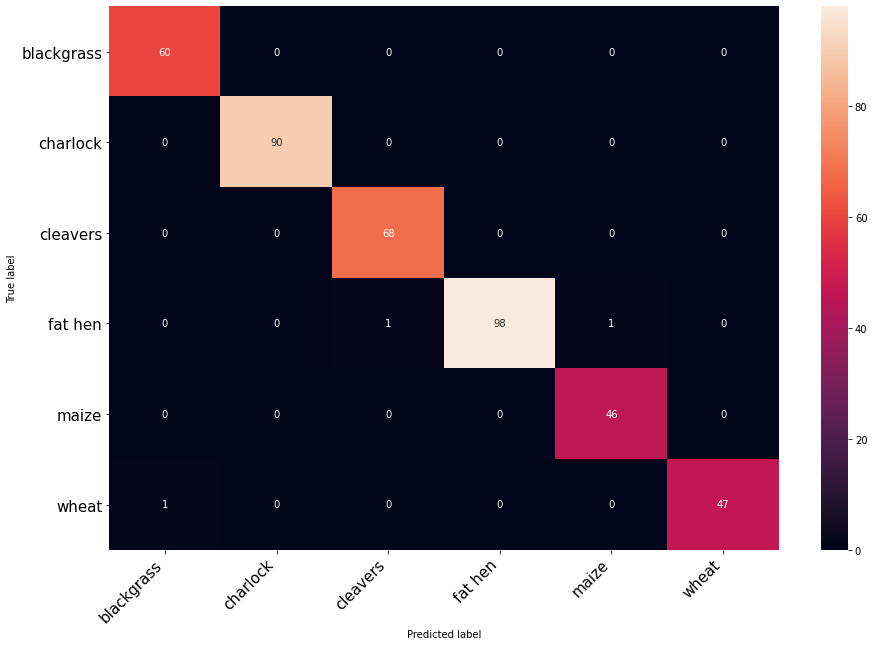

In [ ]:
#Train model
densenet = train_model(densenet, criterion, optimizer_conv, exp_lr_scheduler,
                             num_epochs=25, device=device)

#Call test data
images, labels = next(iter(dataloaders['test']))
#Send images to device to test and send to tensorboard same as model
images = images.to(device)
#Send to tensorboard
writer.add_graph(densenet, images)
#Time to test model
print("Testing model")
#Set confusion matric up as 6x6 (num of classes)
confusion_matrix = torch.zeros(6, 6)
#For loop for test and assigning to confusion matrix for multi class
with torch.no_grad():
    for i, (images, labels) in enumerate(dataloaders['test']):
        #Set images and labels to same device as model
        images = images.to(device)
        labels = labels.to(device)
        #Pass model image
        outputs = densenet(images)
        #Compare model prediction with actual
        _, pred = torch.max(outputs, 1)
        #For loop to add to confusion matrix
        for t, p in zip(labels.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] +=1
#Print matrix created
print(confusion_matrix)
#Find each class accuracy
accuracy_individ = confusion_matrix.diag()/confusion_matrix.sum(1)
#Print each class accuracy
print(accuracy_individ)

#Plot figure for easier understanding of model
plt.figure(figsize=(15,10))
#Set to dataframe for seaborn heatmap
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#Call heatmap with dataframe
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
#Call heatmap with dataframe
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
#Save for later use
conf = root_path + "Conf_matrix_Densenet.png"
plt.savefig(conf)

In [ ]:
#convert accuracies to numpy
accuracy_indi = accuracy_individ.numpy()
#Convert matrix to numpy
matrix = confusion_matrix.numpy()
#Total up each class verical from matrix
totals = np.sum(matrix, axis = 1)
#Total up each class horizontal from matrix
fp_total = np.sum(matrix, axis = 0)

overall_total = sum(totals)

#Evaluation metrics for loop
"""
Paper for metric formulas 
https://www.researchgate.net/publication/275224157_A_Review_on_Evaluation_Metrics_for_Data_Classification_Evaluations
"""
for i in range(6):
  total = totals[i]
  #True positive
  TP = total * accuracy_indi[i]
  #False negative
  FN = total - TP
  #False postitive
  FP = fp_total[i] - TP
  #True negative
  TN = overall_total - TP
  #Accuracy
  Accuracy = (TP + TN)/ (TP + FP + TN + FN)
  #Precision
  Precision = TP / (TP + FP)
  #Recall
  Recall = TP / (TP + FN)
  #Specificity
  Specificity = TN / (TN + FP)
  #F1 score
  F1 = (2*TP) / (2*TP + FP + FN)
  #Matthews correlation coefficient
  MCC = ((TP * TN) - (FP *FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) )
  #Error Rate
  Error_rate = (FP + FN)/ (TP + FP + TN + FN) 
  #Sensitivity
  Sensitivity = TP / (TP +FN)
  #Geometric mean
  GM = np.sqrt((TP*TN))
  #F measure
  F_M = (2*Precision * Recall) / (Precision + Recall)
  #Print results and class
  print(class_names[i].capitalize())
  print("True Positive value = " + str(TP))
  print("False Negative value = " + str(FN))
  print("False Positive value = " + str(FP))
  print("True Negative value = " + str(TN))
  print("Accuracy = " + str(Accuracy))
  print("Precision = " + str(Precision))
  print("Recall = " + str(Recall))
  print("Specificity = " + str(Specificity))
  print("F1 Score = " + str(F1))
  print("MCC = " + str(MCC))
  print("Error Rate = " + str(Error_rate))
  print("Sensitivity = " + str(Sensitivity))
  print("Geometric Mean = " + str(GM))
  print("F-Measure = " + str(F_M))
  print()

#Save the model for later use to be deployed using torchserve
s = torch.jit.script(densenet)
torch.jit.save(s, root_path + 'DenseNet201.pt')

Blackgrass
True Positive value = 60.0
False Negative value = 0.0
False Positive value = 1.0
True Negative value = 352.0
Accuracy = 0.9975786924939467
Precision = 0.9836066
Recall = 1.0
Specificity = 0.9971671388101983
F1 Score = 0.9917355371900827
MCC = 0.99036363853618
Error Rate = 0.002421307506053269
Sensitivity = 1.0
Geometric Mean = 145.3272169966796
F-Measure = 0.9917355471235115

Charlock
True Positive value = 90.0
False Negative value = 0.0
False Positive value = 0.0
True Negative value = 322.0
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
Specificity = 1.0
F1 Score = 1.0
MCC = 1.0
Error Rate = 0.0
Sensitivity = 1.0
Geometric Mean = 170.23513150933329
F-Measure = 1.0

Cleavers
True Positive value = 68.0
False Negative value = 0.0
False Positive value = 1.0
True Negative value = 344.0
Accuracy = 0.9975786924939467
Precision = 0.98550725
Recall = 1.0
Specificity = 0.9971014492753624
F1 Score = 0.9927007299270073
MCC = 0.9912873970921302
Error Rate = 0.002421307506053269
Sensitivity

In [ ]:
#Upload results to tensorboard
!tensorboard dev upload \
  --logdir  runs/DenseNet/\
  --name "DenseNet201  Model" \
  --description "Relevant information on model found here" \
  --one_shot

2021-05-18 14:55:52.434651: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Mxt8NYtySDmJRRx7be1M0g/

[2021-05-18T14:55:54] Started scanning logdir.
E0518 14:55:55.697000 140238466193280 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
E0518 14:55:56.764567 140238466193280 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
E0518 14:55:57.757078 140238466193280 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
[2021-05-18T14:55:57] Total uploaded: 500 scalars, 0 tensors, 1 binary objects (1.1 MB)
Total skipped: 3 binary objects (3.4 MB)
[2021-05-18T14:55:57] Done scanning logdir.


Done. View you